In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
import squidpy as sq
import enrichmap as em
import anndata
import pandas as pd
import numpy as np
import gseapy as gp
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
import time

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from skimage.draw import disk
from scipy.spatial import distance

In [4]:
sc.set_figure_params(dpi=100, facecolor=None, color_map="seismic", frameon=False, vector_friendly=True)
sc.settings._vector_friendly = False

In [5]:
# set working directory
project_dir = "/Users/cenkcelik/Cenk_scoring/"
working_dir = project_dir + ""
os.chdir(working_dir)

# set figure directory
figure_dir = working_dir + "figures/"

# processed data directory
processed_data = working_dir + "processed_data/"

In [6]:
# set random seed
np.random.seed(0)

In [7]:
# Load human gene names from a reference file or database
def load_human_genes(n_genes=15000):
    gene_list = pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_app_sym&status=Approved&hgnc_dbtag=on&order_by=gd_app_sym&format=text", sep="\t")
    return np.random.choice(gene_list["Approved symbol"].values, n_genes, replace=False)

# Generate hexagonal grid for 10X Visium-like spatial coordinates
def generate_hexagonal_grid(rows=70, cols=70, spacing=50):
    x_coords, y_coords = [], []
    for row in range(rows):
        for col in range(cols):
            x = col * spacing + (row % 2) * (spacing / 2)
            y = row * spacing * np.sqrt(3) / 2
            x_coords.append(x)
            y_coords.append(y)
    return np.array(x_coords), np.array(y_coords)

# Assign biological labels in spatially coherent clusters
def assign_spatial_clusters(x_coords, y_coords, labels):
    num_spots = len(x_coords)
    label_assignment = np.random.choice(labels, num_spots, replace=True)
    
    for i in range(num_spots):
        nearest_neighbours = distance.cdist([(x_coords[i], y_coords[i])], np.column_stack((x_coords, y_coords))).flatten()
        close_spots = np.argsort(nearest_neighbours)[1:4]
        label_assignment[close_spots] = label_assignment[i] # Increase local clustering
    
    return label_assignment

# Simulate expression matrix
def generate_expression_matrix(n_spots, n_genes, labels, gene_signature):
    expression_matrix = np.random.poisson(5, (n_spots, n_genes))
    
    # Boost state gene expression in made up-labelled spots
    made_up_spots = np.where(labels == "cluster_2")[0]
    expression_matrix[made_up_spots[:, None], gene_signature] *= 5
    
    return expression_matrix

# generate a number between 0-255
def random_color():
    return np.random.randint(0, 256)

# Generate a dummy tissue image
def generate_tissue_image(image_size=(2000, 2000)):
    image = np.ones((*image_size, 3), dtype=np.uint8) * 252
    rr, cc = disk((500, 500), 300, shape=image.shape[:2])
    image[rr, cc] = [random_color(), random_color(), random_color()]
    return image

# Main function to generate simulated spatial AnnData
def generate_spatial_cancer_data(seed=0):
    np.random.seed(seed)
    
    n_genes = 15000
    x_coords, y_coords = generate_hexagonal_grid()
    n_spots = len(x_coords)
    gene_names = load_human_genes(n_genes)
    
    # Define labels
    labels = np.array(["cluster_1", "cluster_2", "cluster_3", "cluster_4"])
    assigned_labels = assign_spatial_clusters(x_coords, y_coords, labels)
    
    # Pick Made-up spots-related genes
    spot_gene_indices = np.random.choice(n_genes, size=100, replace=False)
    
    # Generate expression data
    expression_matrix = generate_expression_matrix(n_spots, n_genes, assigned_labels, spot_gene_indices)
    
    # Create AnnData object
    adata = anndata.AnnData(X=expression_matrix)
    adata.var_names = gene_names
    adata.obs["cluster"] = assigned_labels
    adata.obsm["spatial"] = np.column_stack((x_coords, y_coords))
    
    # Add Visium-like metadata
    adata.uns["spatial"] = {
        "image_1": {
            "images": {
                "hires": generate_tissue_image(),
                "lowres": generate_tissue_image((500, 500))
            },
            "metadata": {
                "chemistry_description": "Spatial 3' v1",
                "software_version": "spaceranger-1.2.2"
            },
            "scalefactors": {
                "fiducial_diameter_fullres": 28.89725002221966,
                "spot_diameter_fullres": 17.888773823278836,
                "tissue_hires_scalef": 0.856531,
                "tissue_lowres_scalef": 0.25695932
            }
        }
    }
    
    return adata

In [8]:
adata = generate_spatial_cancer_data(seed=0)

In [9]:
cluster_palettes = {
    "cluster_1": "#F6C141",
    "cluster_2": "#882E72",
    "cluster_3": "#7BAFDE",
    "cluster_4": "#F4A582"
}

# Convert 'cluster' column to categorical dtype
adata.obs["cluster"] = pd.Categorical(adata.obs["cluster"])

# Now you can access the categories
clusters = adata.obs["cluster"].cat.categories

# Reorder the palette list to match the category order
palette_list = [cluster_palettes[c] for c in clusters]

# Create a ListedColormap
cmap = ListedColormap(palette_list)

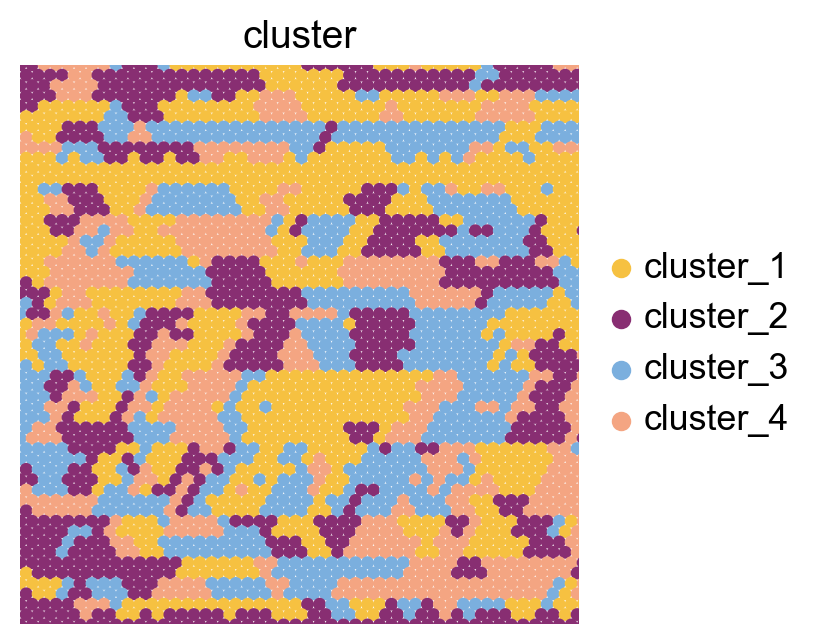

In [10]:
sq.pl.spatial_scatter(adata, color="cluster", img_alpha=0, size=3, palette=cmap, save=figure_dir + "spatial_scatter_simulated_clusters.pdf")

In [11]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [12]:
sc.tl.rank_genes_groups(adata, groupby="cluster", method="t-test_overestim_var", use_raw=False)
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.5, min_fold_change=2, max_out_group_fraction=0.5)

In [13]:
gene_set_10 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:10].tolist()

### EnrichMap

In [14]:
t1 = time.time()
em.tl.score(
    adata,
    gene_set=gene_set_10,
    smoothing=True,
    correct_spatial_covariates=True,
    batch_key=None
)
t2=time.time()
print(t2-t1)

Scoring signatures: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

0.2952718734741211


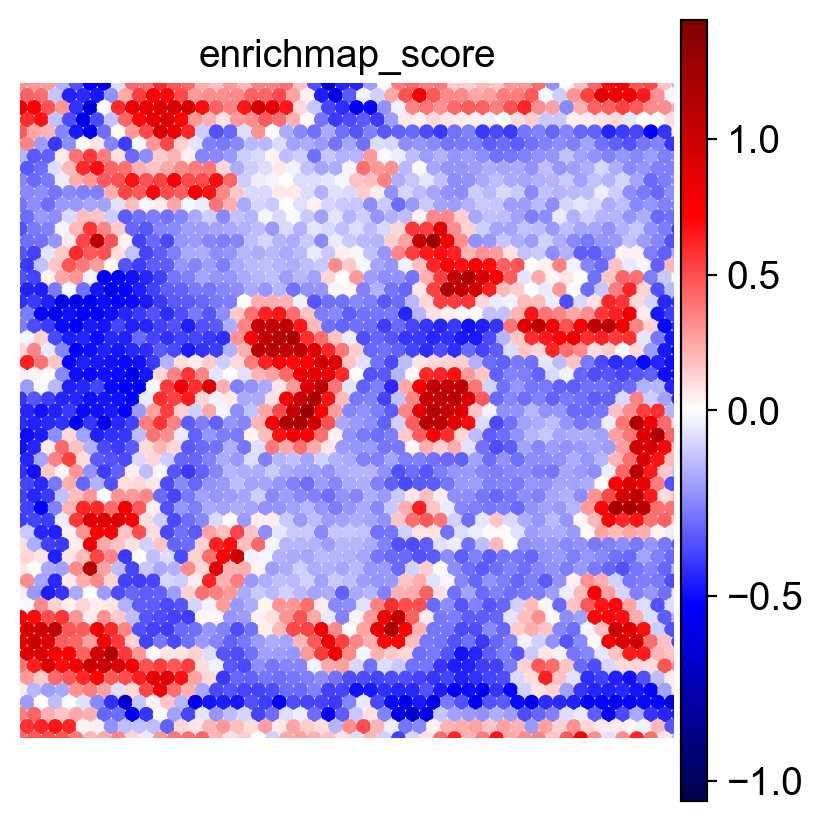

In [15]:
sq.pl.spatial_scatter(adata, color=["enrichmap_score"], img_alpha=0, size=3, vcenter=0, save=figure_dir + "spatial_scatter_enrichmap_score.pdf")

### AUCell

In [16]:
# convert the signature dict to a long format
signatures_dict_10 = {
    "cluster_2": gene_set_10
}

signatures_10 = pd.DataFrame(
    [(key, gene) for key, genes in signatures_dict_10.items() for gene in genes],
    columns=["geneset", "genesymbol"]
)

t1 = time.time()
dc.run_aucell(
    adata,
    net=signatures_10,
    source="geneset",
    target="genesymbol",
    seed=0,
    verbose=True,
    use_raw=False
)
t2=time.time()
print(t2-t1)

acts = dc.get_acts(adata, obsm_key="aucell_estimate")

adata.obs["aucell_score"] = acts.obsm["aucell_estimate"]["cluster_2"]

Running aucell on mat with 4900 samples and 15000 targets for 1 sources.


100%|██████████| 4900/4900 [00:06<00:00, 745.81it/s]

7.25390887260437


## `score_genes()`/`AddModuleScore()`

In [17]:
t1 = time.time()
sc.tl.score_genes(adata, gene_set_10, score_name="scanpy_score", use_raw=False)
t2=time.time()
print(t2-t1)

0.16765809059143066


## ssGSEA

In [18]:
# If adata.X is sparse, convert to dense first
X_dense = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X

# Create DataFrame using var names as columns and obs names as index
gene_expr = pd.DataFrame(X_dense.T, index=adata.var_names, columns=adata.obs_names)

In [19]:
gene_expr.index = gene_expr.index.str.upper()
signatures_dict_10 = {k: [g.upper() for g in v] for k, v in signatures_dict_10.items()}

In [20]:
t1 = time.time()
ssgsea = gp.ssgsea(
    data=gene_expr,
    gene_sets=signatures_dict_10,
    outdir=None,
    sample_norm_method="rank",
    no_plot=True,
    min_size=5
)
t2=time.time()
print(t2-t1)

21.18958306312561


In [21]:
nes = ssgsea.res2d.pivot(index="Term", columns="Name", values="NES")
adata.obs["ssgsea_score"] = nes.loc["cluster_2"].T.astype(float).reindex(adata.obs_names)

### GSVA

In [22]:
t1 = time.time()
gsva = gp.gsva(
    data=gene_expr,
    gene_sets=signatures_dict_10,
    outdir=None,
    min_size=5
)
t2=time.time()
print(t2-t1)

496.7310609817505


In [23]:
es = gsva.res2d.pivot(index="Term", columns="Name", values="ES")
adata.obs["gsva_score"] = es.loc["cluster_2"].T.astype(float).reindex(adata.obs_names)

### Z score

In [24]:
gene_set = signatures_dict_10["cluster_2"]
t1 = time.time()
z_score = gene_expr.loc[gene_set].sum(axis=0) / np.sqrt(len(gene_set))
t2=time.time()
print(t2-t1)
adata.obs["z_score"] = z_score

0.0969851016998291


In [25]:
methods = ["enrichmap_score", "aucell_score", "z_score", "scanpy_score", "ssgsea_score", "gsva_score"]

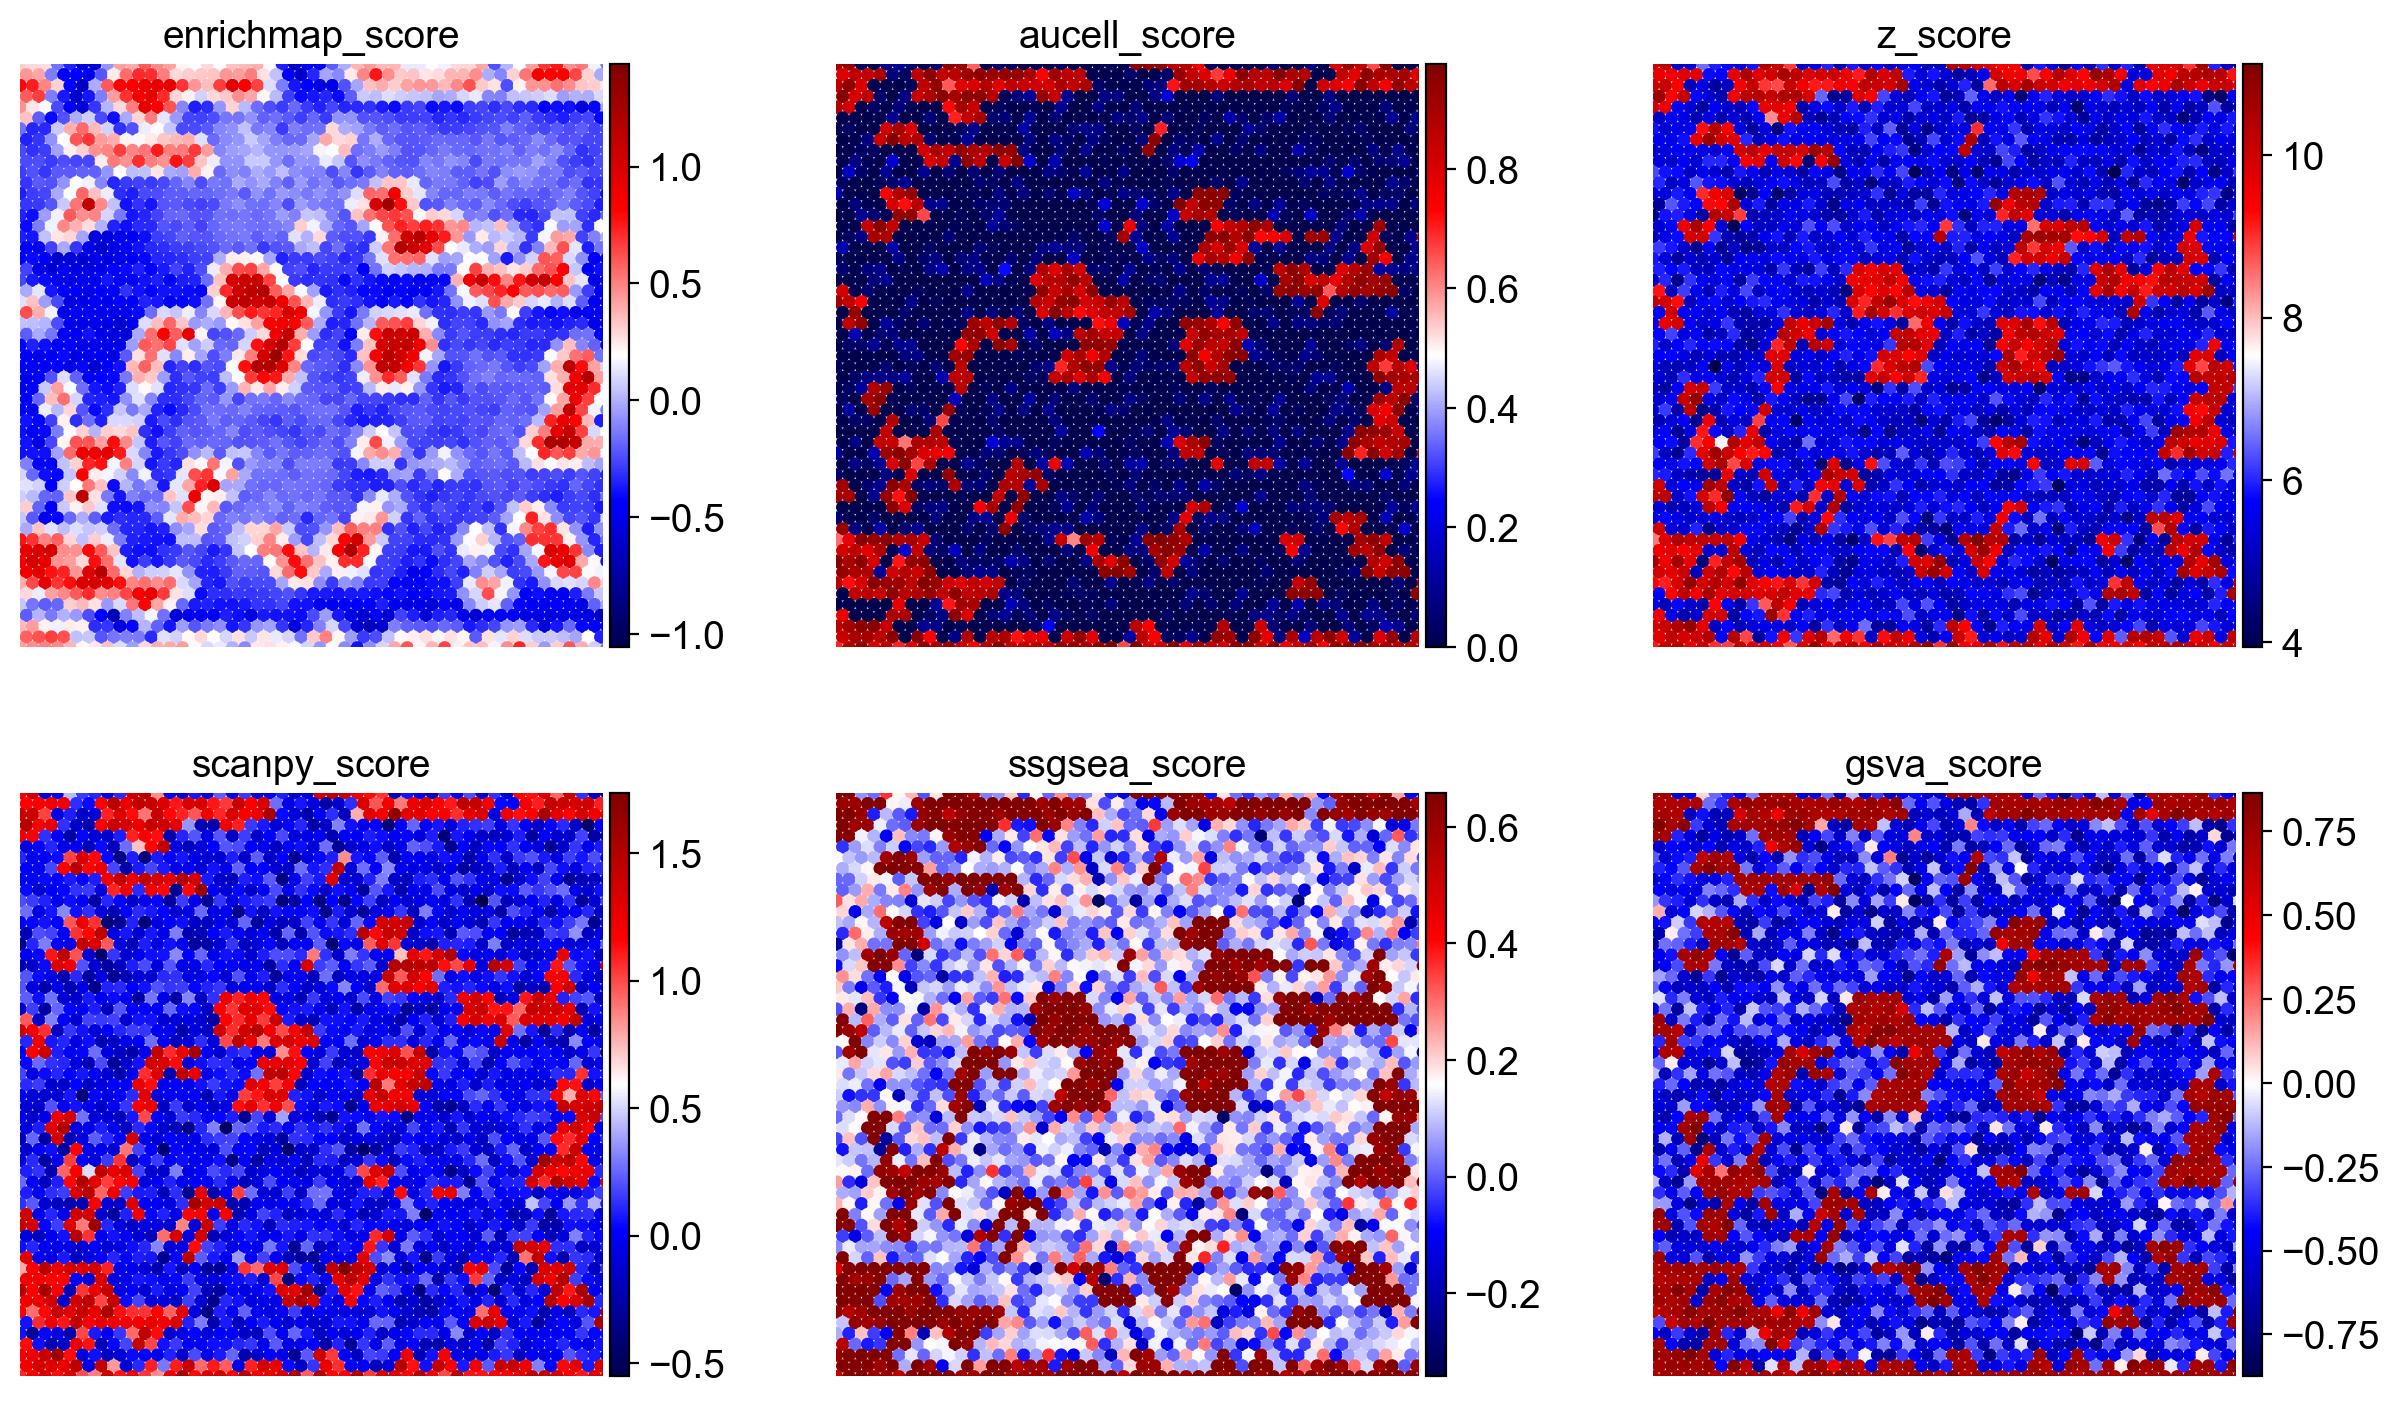

In [26]:
sq.pl.spatial_scatter(
    adata,
    color=methods,
    img_alpha=0,
    size=3,
    ncols=3,
    save=figure_dir + "spatial_scatter_simulated_score_comparison.pdf",
)

Computing Moran's I for enrichmap_score with 6 neighbours...
Computing Moran's I for aucell_score with 6 neighbours...
Computing Moran's I for z_score with 6 neighbours...
Computing Moran's I for scanpy_score with 6 neighbours...
Computing Moran's I for ssgsea_score with 6 neighbours...
Computing Moran's I for gsva_score with 6 neighbours...


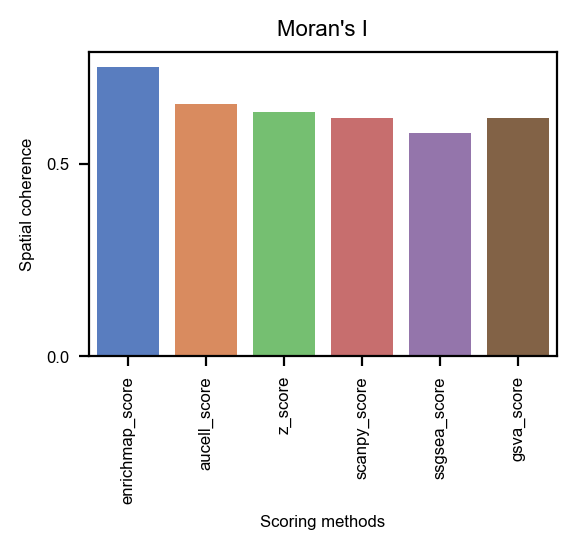

In [27]:
em.pl.spatial_metrics(adata, methods, metric="Moran's I", figsize=(3, 2), save=figure_dir + "spatial_metrics_simulated_moransI.pdf")

Computing Geary's C for enrichmap_score with 6 neighbours...
Computing Geary's C for aucell_score with 6 neighbours...
Computing Geary's C for z_score with 6 neighbours...
Computing Geary's C for scanpy_score with 6 neighbours...
Computing Geary's C for ssgsea_score with 6 neighbours...
Computing Geary's C for gsva_score with 6 neighbours...


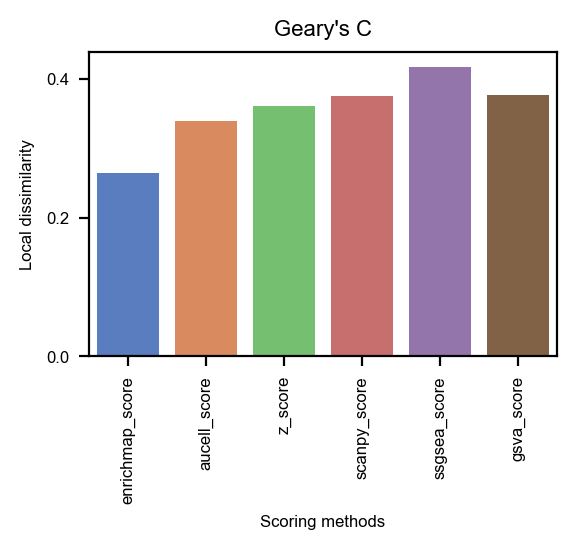

In [28]:
em.pl.spatial_metrics(adata, methods, metric="Geary's C", figsize=(3, 2), save=figure_dir + "spatial_metrics_simulated_gearysC.pdf")

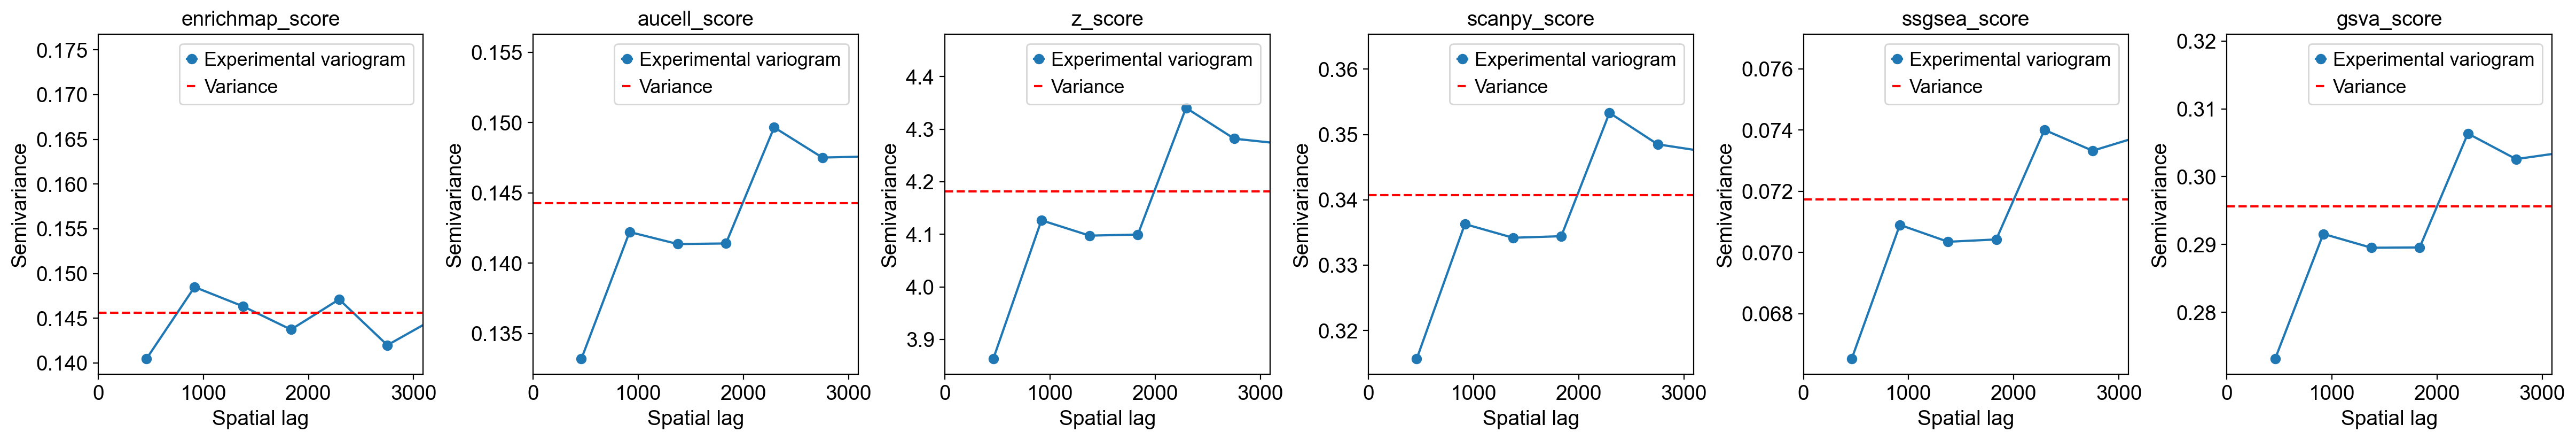

In [29]:
em.pl.variogram(
    adata,
    score_keys=methods,
    save="variogram_simulated_method_comparison.pdf",
)

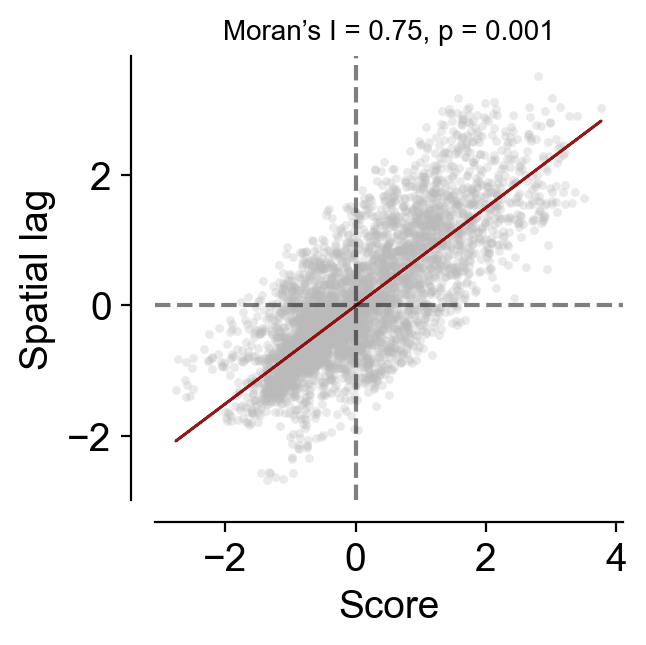

In [30]:
em.pl.morans_correlogram(
    adata,
    score_key="enrichmap_score",
    save="morans_correlogram_enrichmap_score.pdf",
)

## Gene set sensitivity

In [31]:
gene_set_2 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:2].tolist()
gene_set_5 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:5].tolist()
gene_set_10 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:10].tolist()
gene_set_20 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:20].tolist()
gene_set_50 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:50].tolist()
gene_set_100 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:100].tolist()
gene_set_200 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:200].tolist()
gene_set_500 = adata.uns["rank_genes_groups"]["names"]["cluster_2"][:500].tolist()

In [32]:
# generate a dict
gene_set_sensitivity_dict = {
    "N_genes=2": gene_set_2,
    "N_genes=5": gene_set_5,
    "N_genes=10": gene_set_10,
    "N_genes=20": gene_set_20,
    "N_genes=50": gene_set_50,
    "N_genes=100": gene_set_100,
    "N_genes=200": gene_set_200,
    "N_genes=500": gene_set_500
}

In [33]:
score_keys = [
    "N_genes=2_score",
    "N_genes=5_score",
    "N_genes=10_score",
    "N_genes=20_score",
    "N_genes=50_score",
    "N_genes=100_score",
    "N_genes=200_score",
    "N_genes=500_score"
]

In [34]:
em.tl.score(
    adata,
    gene_set=gene_set_sensitivity_dict,
    smoothing=True,
    correct_spatial_covariates=True,
    batch_key=None
)

Scoring signatures: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


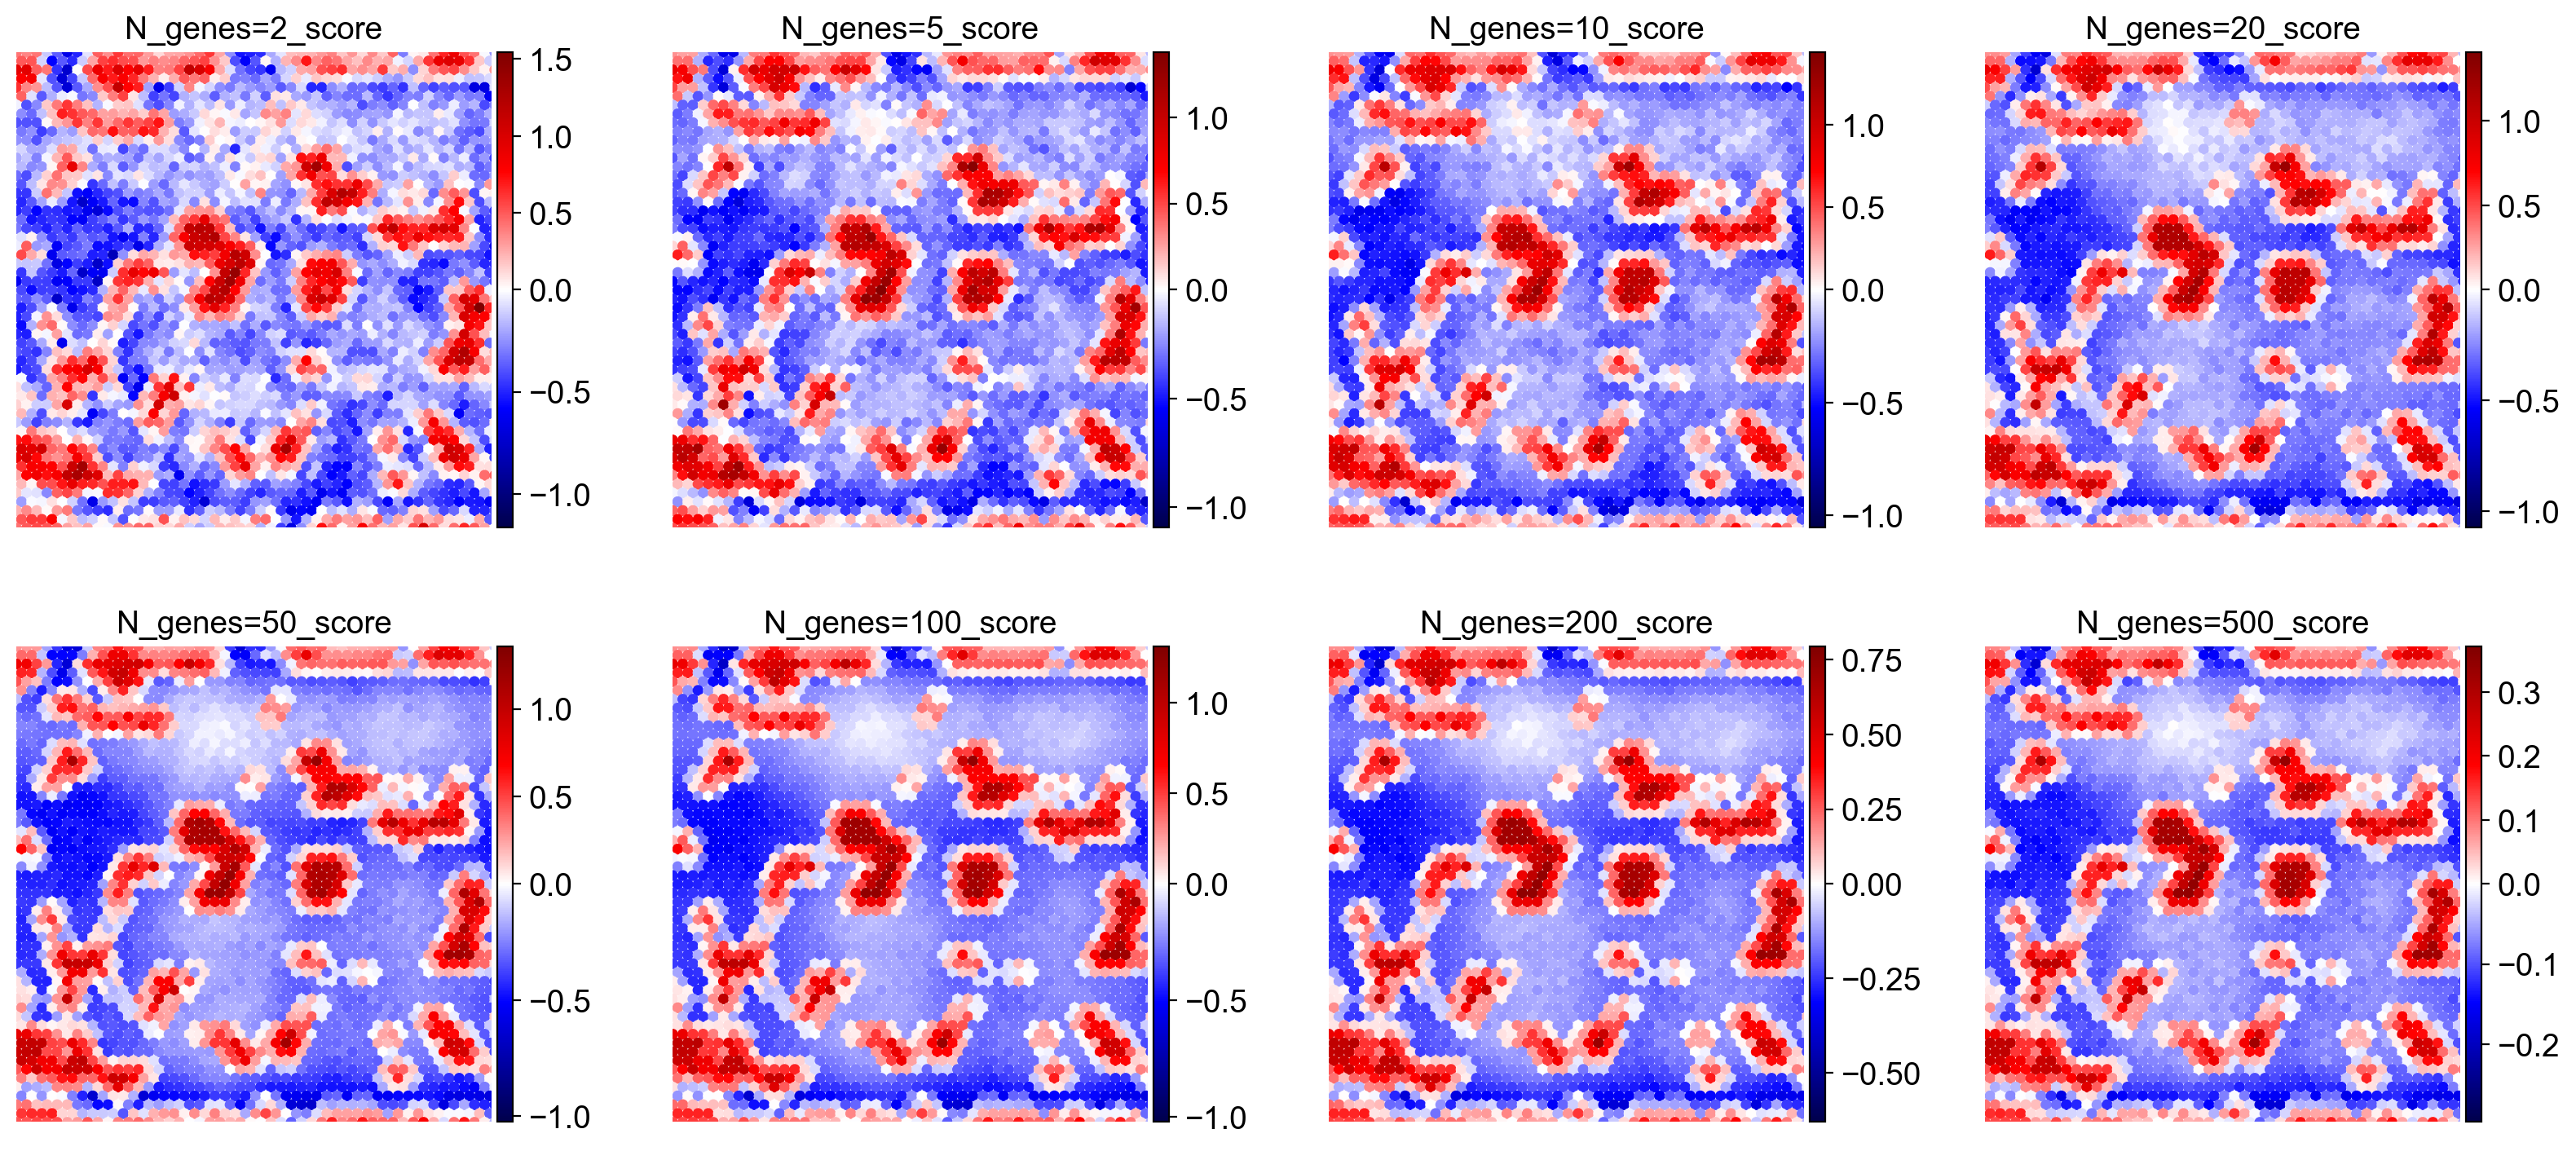

In [35]:
em.pl.spatial_enrichmap(
    adata,
    score_key=score_keys,
    img_alpha=0,
    size=3,
    ncols=4,
    save=figure_dir + "spatial_enrichmap_gene_set_sensitivity_score_comparison.pdf",
)

Computing Moran's I for enrichmap_score with 6 neighbours...
Computing Moran's I for aucell_score with 6 neighbours...
Computing Moran's I for z_score with 6 neighbours...
Computing Moran's I for scanpy_score with 6 neighbours...
Computing Moran's I for ssgsea_score with 6 neighbours...
Computing Moran's I for gsva_score with 6 neighbours...


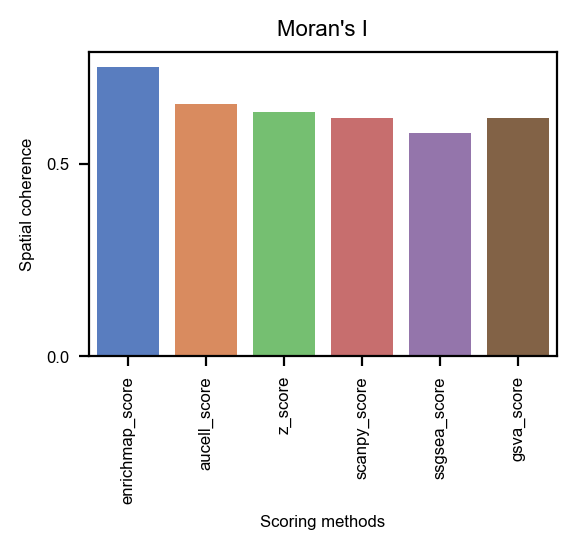

In [36]:
em.pl.spatial_metrics(adata, methods, metric="Moran's I", figsize=(3,2), save=figure_dir + "spatial_metrics_gene_set_sensitivity_moransI.pdf")

Computing Geary's C for enrichmap_score with 6 neighbours...
Computing Geary's C for aucell_score with 6 neighbours...
Computing Geary's C for z_score with 6 neighbours...
Computing Geary's C for scanpy_score with 6 neighbours...
Computing Geary's C for ssgsea_score with 6 neighbours...
Computing Geary's C for gsva_score with 6 neighbours...


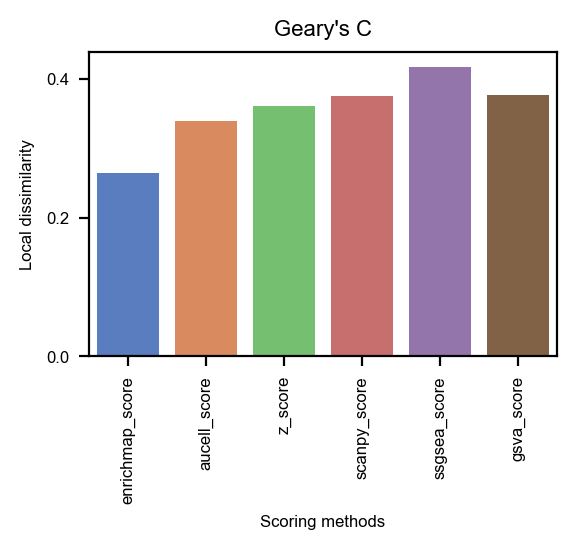

In [37]:
em.pl.spatial_metrics(adata, methods, metric="Geary's C", figsize=(3,2), save=figure_dir + "spatial_metrics_gene_set_sensitivity_gearysC.pdf")

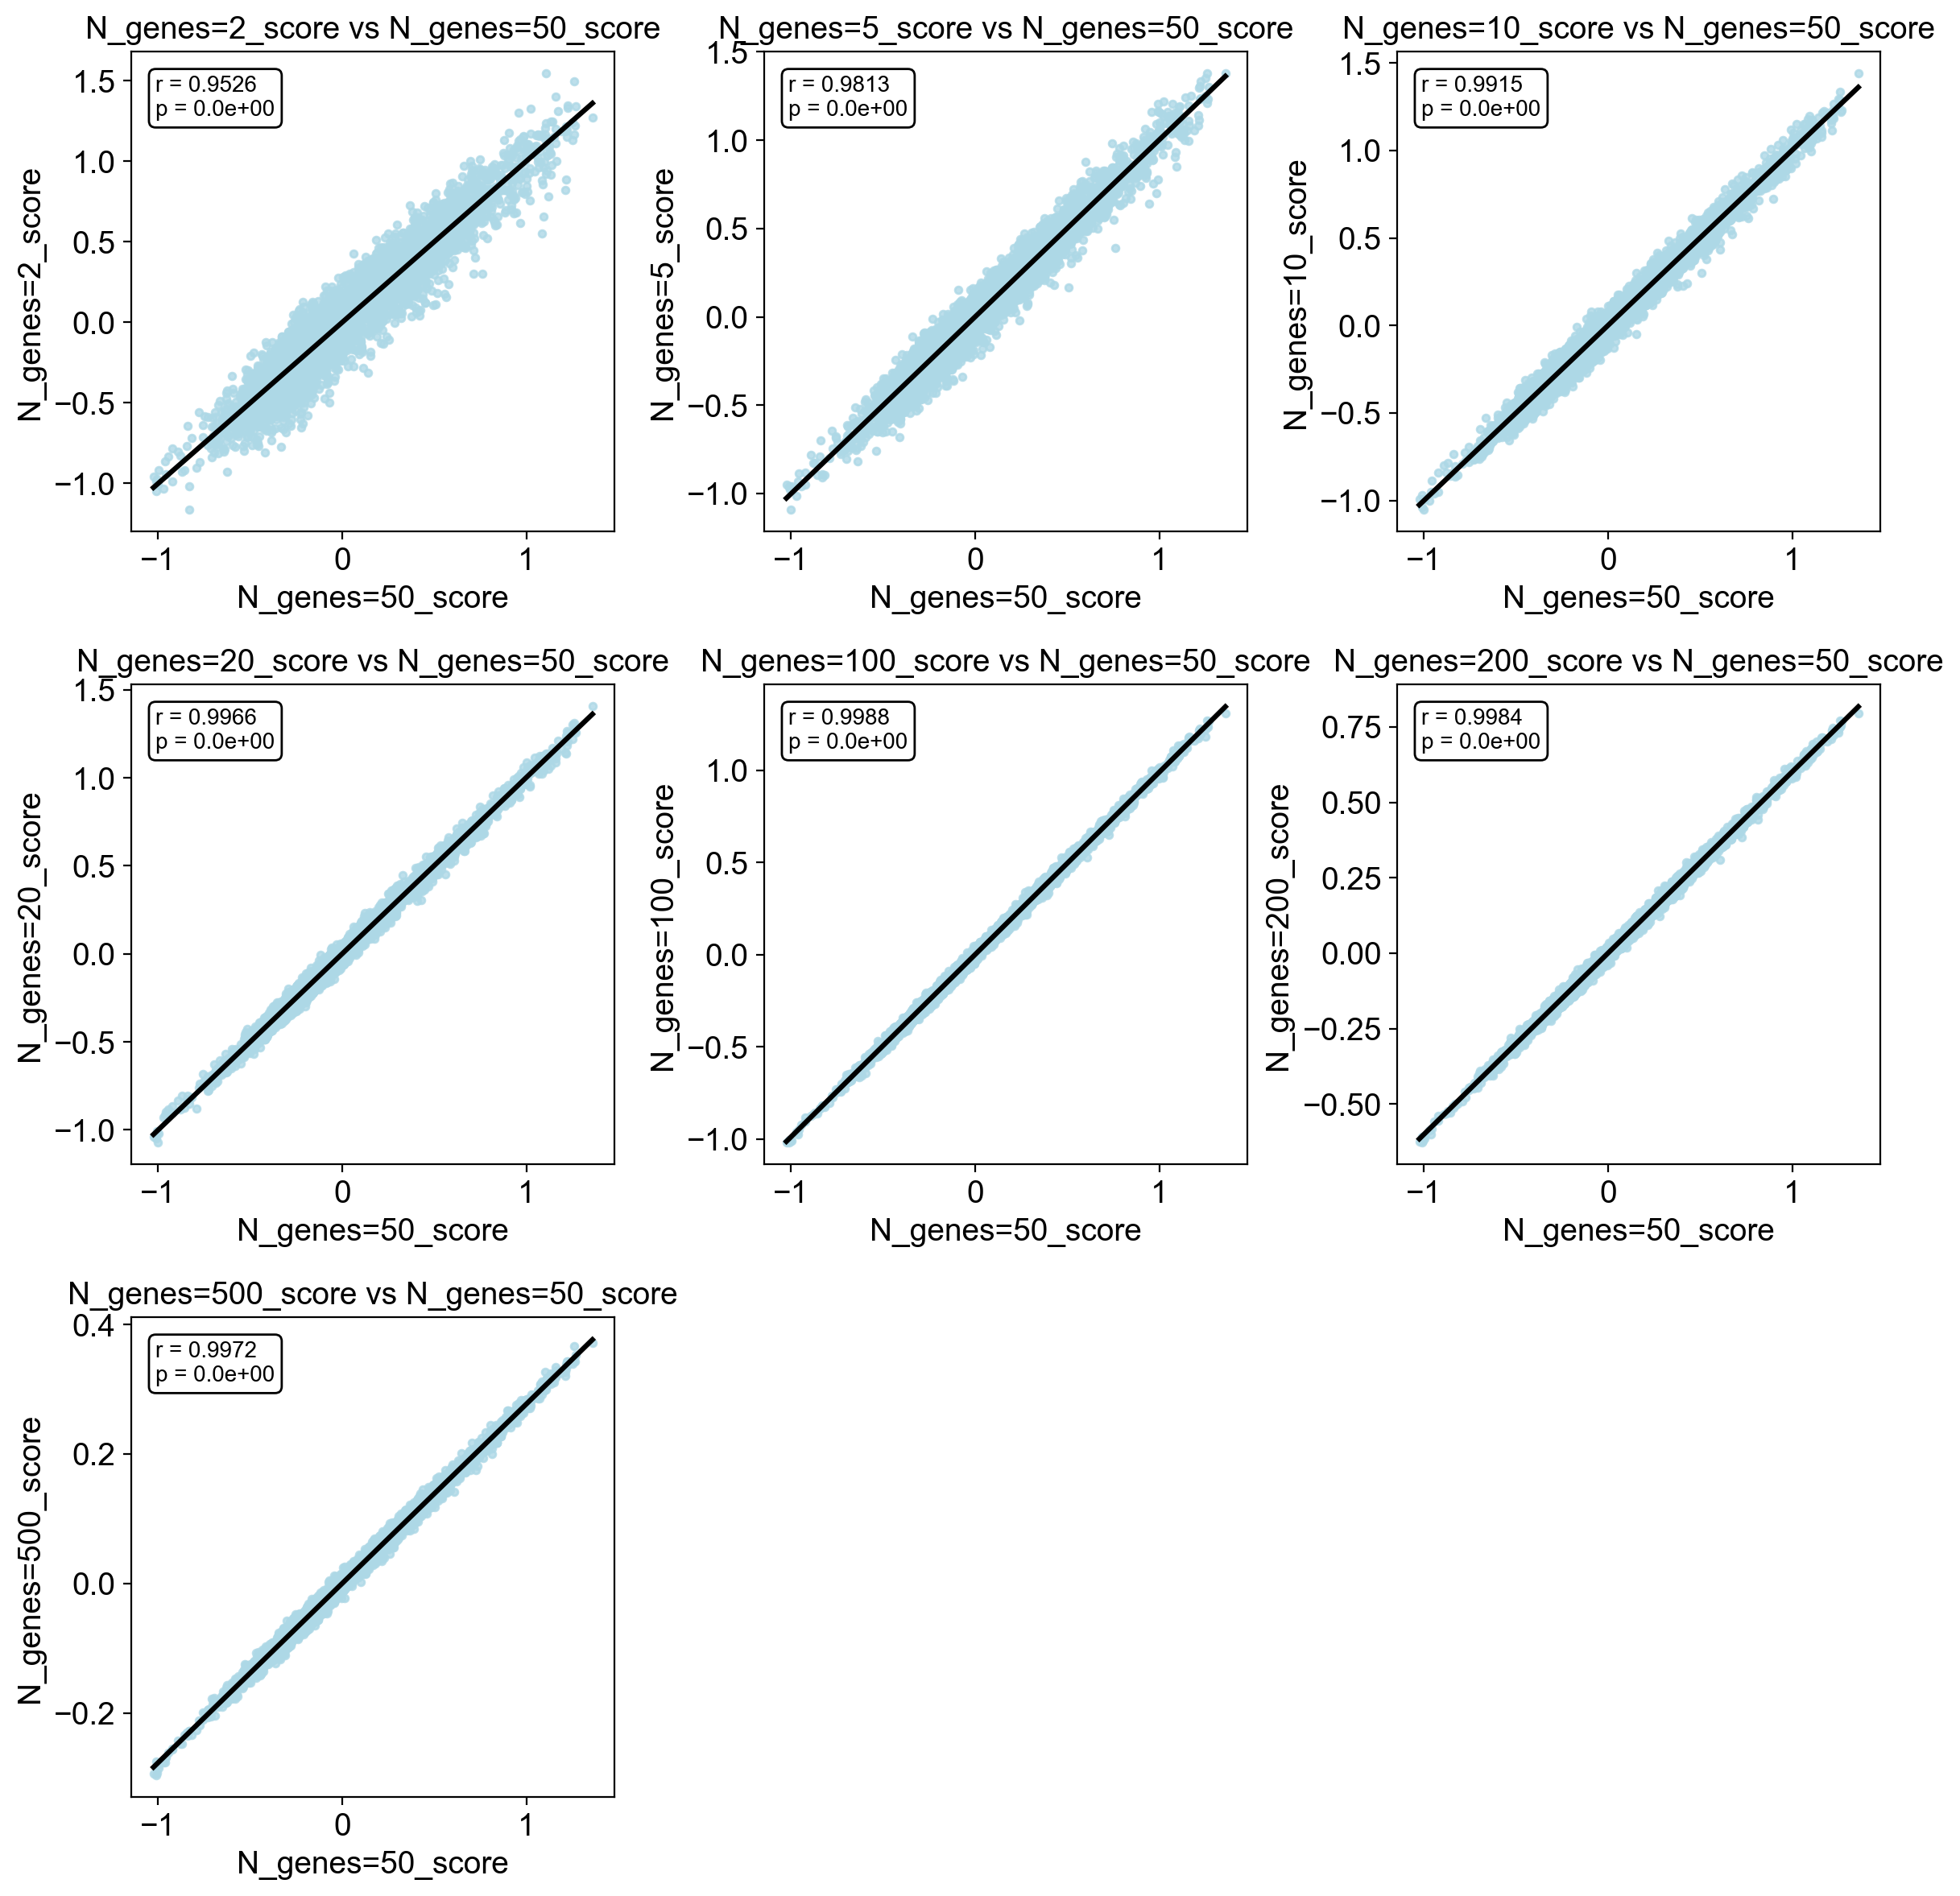

In [38]:
# List of gene score labels to compare with the reference
scores = ["2", "5", "10", "20", "100", "200", "500"]
x_label = "N_genes=50_score"

# Set up the figure with subplots
n_plots = len(scores)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, score in enumerate(scores):
    y_label = f"N_genes={score}_score"
    df = adata.obs[[x_label, y_label]].dropna()

    corr, pval = pearsonr(df[x_label], df[y_label])

    ax = axes[i]
    sns.regplot(x=x_label, y=y_label, data=df,
                scatter_kws={"s": 10, "color": "lightblue"},
                line_kws={"color": "black"},
                ax=ax)

    ax.set_title(f"{y_label} vs {x_label}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.text(0.05, 0.95,
            f"r = {corr:.4f}\np = {pval:.1e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))
    ax.grid(False)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(figure_dir + "spatial_enrichmap_gene_set_sensitivity_score_correlation.pdf", bbox_inches="tight")
plt.show()

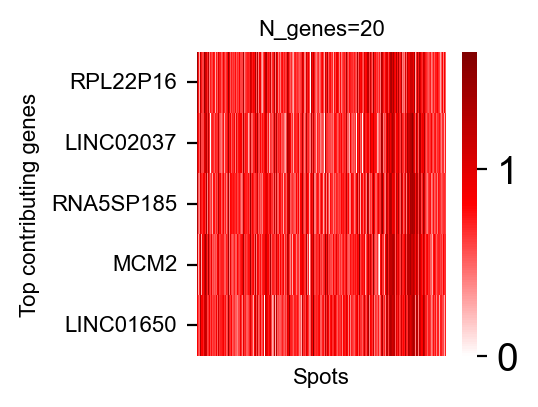

In [39]:
em.pl.gene_contributions_heatmap(
    adata,
    score_key="N_genes=20",
    top_n_genes=5,
    figsize=(2, 2),
    save=figure_dir + "spatial_enrichmap_gene_set_sensitivity_top_5_contributions.pdf"
)

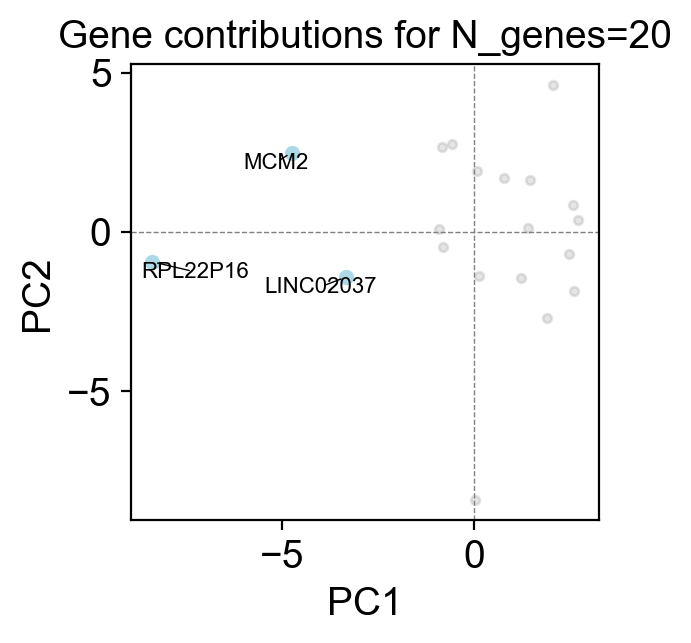

In [40]:
em.pl.gene_contributions_pca(
    adata,
    score_key="N_genes=20",
    top_n_genes=3,
    figsize=(3, 3),
    save=figure_dir + "spatial_enrichmap_gene_contributions_pca.pdf"
)

KeyError: 'Could not find key RNU6-935P in .var_names or .obs.columns.'

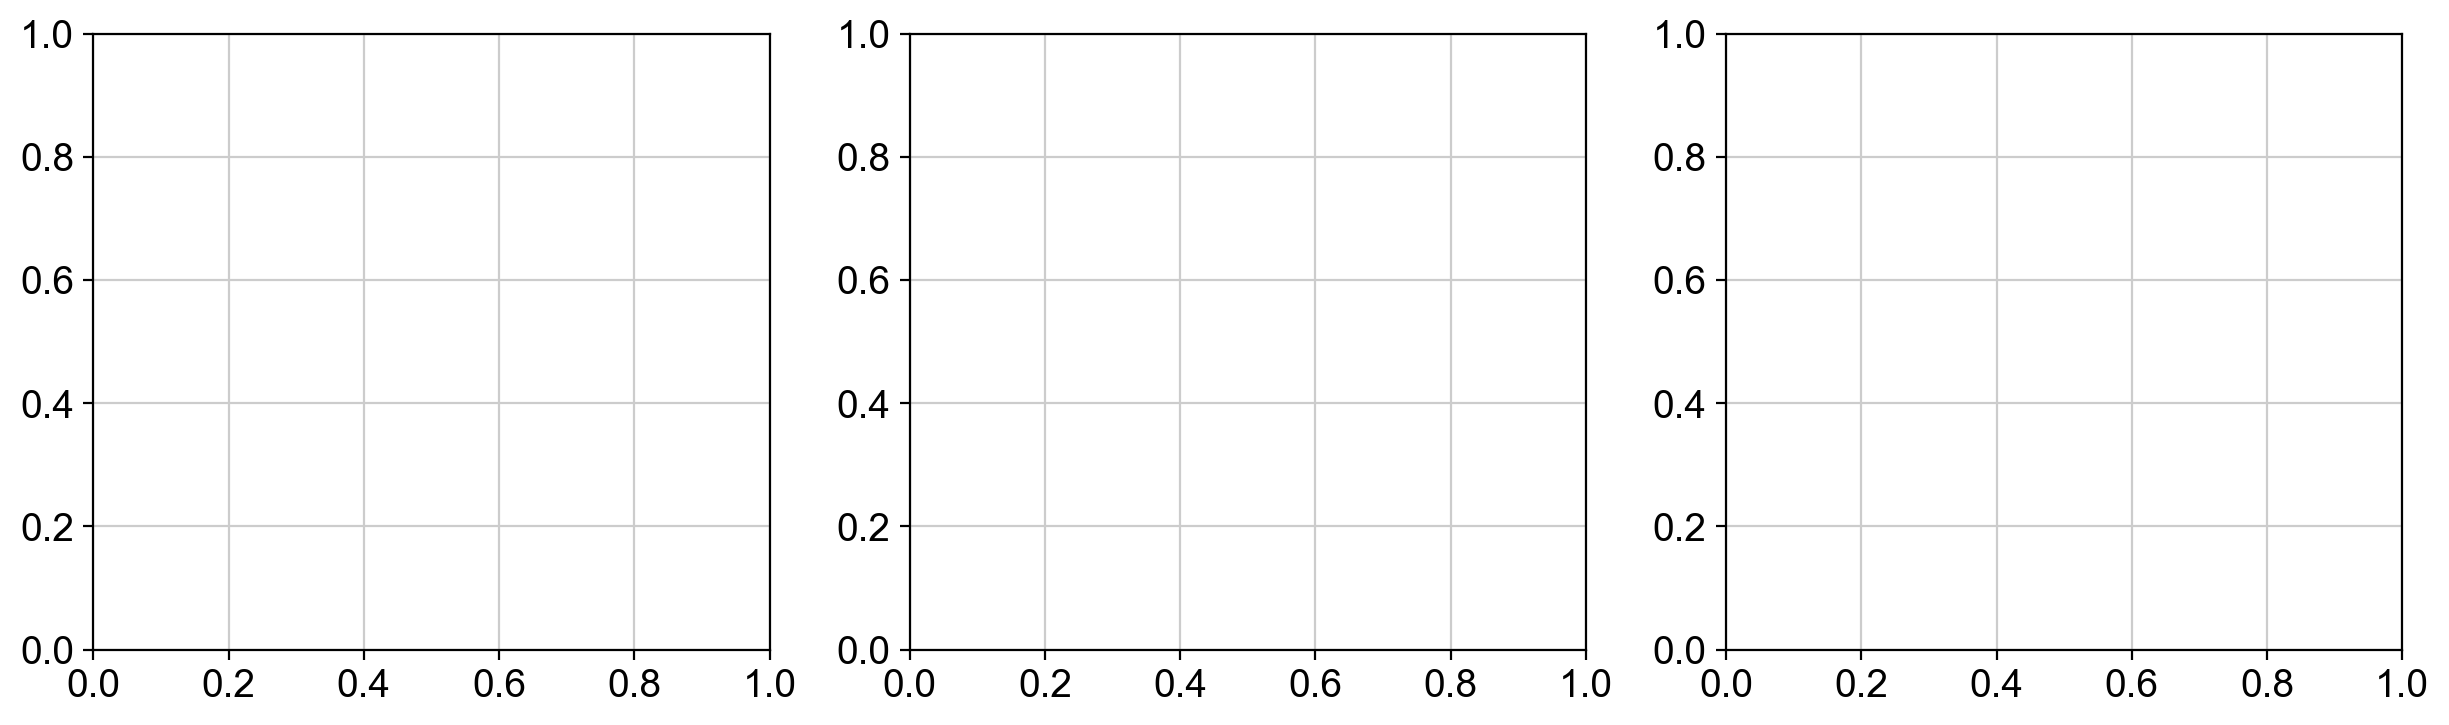

In [41]:
sq.pl.spatial_scatter(
    adata,
    color=["RNU6-935P", "CFAP47", "AOC3"],
    size=3,
    use_raw=False,
    img_alpha=0,
    ncols=3,
    cmap="PuOr",
    save=figure_dir + "spatial_scatter_simulated_genes.pdf",
)

In [ ]:
em.pl.variogram(
    adata,
    score_keys=score_keys,
    save="variogram_simulated_geneset_comparison.pdf",
)

In [ ]:
signature_name = "enrichmap"
binary_labels = em.tl.generate_binary_labels(adata, signature_name)
methods = [
    "enrichmap_score",
    "aucell_score",
    "z_score",
    "scanpy_score",
    "ssgsea_score",
    "gsva_score"
]
f1_scores = em.tl.compute_f1_scores(adata, methods, binary_labels)


In [ ]:
f1_scores = em.tl.compute_f1_scores(adata, score_keys, binary_labels)


In [ ]:
em.pl.variogram_all(
    adata,
    score_keys=methods,
    save="variogram_all_simulated_method_comparison.pdf",
)

## Number of neighbours

In [ ]:
# loop over different neighbors
for n_neighbors in range(1, 21, 1):
    # calculate the score
    em.tl.score(
        adata,
        gene_set=gene_set_10,
        score_key=f"{n_neighbors}_neighbors",
        smoothing=True,
        n_neighbors=n_neighbors,
        correct_spatial_covariates=True,
        batch_key=None
    )

In [ ]:
score_keys = [f"{n_neighbors}_neighbors_score" for n_neighbors in range(1, 21, 1)]

# plot the scores
em.pl.spatial_enrichmap(
    adata,
    score_key=score_keys,
    shape=None,
    size=3,
    ncols=5
)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Coordinates of spots (2D array: n_spots x 2)
coords = adata.obsm['spatial']  # e.g. Visium spatial coords

max_k = 20  # max neighbours to test
nbrs = NearestNeighbors(n_neighbors=max_k + 1).fit(coords)
distances, indices = nbrs.kneighbors(coords)

# distances includes distance to self at index 0, so skip it
distances = distances[:, 1:]  # shape: (n_spots, max_k)

# Calculate mean distance to k-th neighbour over all spots
mean_distances = distances.mean(axis=0)  # length max_k

plt.plot(range(1, max_k + 1), mean_distances, marker='o')
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Mean distance to k-th neighbour (µm)')
plt.title('Mean distance to k-th nearest neighbour')
plt.grid(False)
plt.show()